In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.ndimage.filters import percentile_filter
%matplotlib inline
import time

In [30]:
loaded = np.load('prey.npz') # TODO path to file
X, y = loaded['inputs'], loaded['targets']

In [42]:
X_new = X[:2]
y_new = y[:2]
np.savez_compressed('prey_small.npz', inputs=X_new, targets=y_new) # TODO path to file

In [32]:
event = X[0]

In [38]:
# Find start point of tail
# We just assume that the previous preprocessing procedure has put the tail into the vertical center,
# and kept the tail at the y-axis
start_point = np.array([10, int(event[0].shape[0]/2)]) # left-most, vertical center (0,128)




In [34]:
display = False
direction = 'right'

In [40]:
directions={"up":[0,-1],"down":[0,1],"left":[-1,0],"right":[1,0]}
fitted_tail=[]

frame = event[0]
max_points = 200 #mostly in case it somehow gets stuck in a loop, and to preallocate the result array
frame_fit = np.zeros((max_points,2))
first_frame=True
widths, convolveresults = [],[]
test,slices = [], []
while type(frame) != type(None):
    if display:
        frame_display=frame.copy()
    if direction:
        guess_vector = np.array(directions[direction])
    else:
        raise Exception('Need to define a direction!') #could ask here

    if first_frame:
        if type(start_point)==type(np.array([])) or type(start_point) is list:
            current=np.array(start_point)
            point = current
        else:
            raise Exception('Need to define a direction')
            
        if frame.ndim == 2:
            hist = np.histogram(frame[:,:],10,(0,255))
        elif frame.ndim == 3:
            hist = np.histogram(frame[:,:,0],10,(0,255))
        else:
            raise Exception('Unknown video format!')
            
        background=hist[1][hist[0].argmax()]/2+hist[1][min(hist[0].argmax()+1,len(hist[0])) ]/2
        #find background - 10 bin hist of frame, use most common as background
        if frame.ndim == 2:
            fish = frame[point[1]-2:point[1]+2,point[0]-2:point[0]+2].mean()
        elif frame.ndim == 3:
            fish = frame[point[1]-2:point[1]+2,point[0]-2:point[0]+2,0].mean()
        #find fish luminosity - area around point
        print("Starting tailfit")

        guess_line_width = 51
        normpdf = norm.pdf(np.arange((-guess_line_width+1)/4+1,(guess_line_width-1)/4),0,8) #gaussian kernel, used to find middle of tail           
        if display:
            cv2.namedWindow("frame_display")
            cv2.moveWindow("frame_display",x_window,y_window)
        starttime = time.time()

        time.sleep(5)

    else:
        current= fitted_tail[-1][0,:]

    tailpoint_spacing = 5  #change this multiplier to change the point spacing
    for count in range(max_points):

        if count == 0:
            guess = current
        elif count == 1:
            guess = current + guess_vector*tailpoint_spacing #can't advance guess vector, since we didn't move from our previous point
        else:
            guess_vector=guess_vector/(((guess_vector**2).sum())**.5) #normalize guess vector
            guess = current + guess_vector*tailpoint_spacing
        guess_line_start = guess + np.array([-guess_vector[1],guess_vector[0]])*guess_line_width/2
        guess_line_end = guess + np.array([guess_vector[1],-guess_vector[0]])*guess_line_width/2
        x_indices = np.int_(np.linspace(guess_line_start[0],guess_line_end[0],guess_line_width))
        y_indices = np.int_(np.linspace(guess_line_start[1],guess_line_end[1],guess_line_width))

        if max(y_indices) >= frame.shape[0] or min(y_indices) < 0 or max(x_indices) >= frame.shape[1] or min(x_indices) < 0:
            y_indices = np.clip(y_indices,0, frame.shape[0]-1)
            x_indices = np.clip(x_indices,0, frame.shape[1]-1)
            print("Tail got too close to the edge of the frame, clipping search area!")
            #TODO if too many values are clipped, break?

        guess_slice= frame[y_indices,x_indices] #the frame is transposed compared to what might be expected
        if guess_slice.ndim == 2:
            guess_slice=guess_slice[:,0]
        else:
            guess_slice=guess_slice[:]

        if fish < background:
            guess_slice = (background-guess_slice)
        else:
            guess_slice = (guess_slice-background)

        slices += [guess_slice]
        hist = np.histogram(guess_slice, 10)
        guess_slice = guess_slice-guess_slice[((hist[1][hist[0].argmax()]<=guess_slice)& (guess_slice<hist[1][hist[0].argmax()+1]))].mean()
        #baseline subtraction

        sguess = percentile_filter(guess_slice,50,5) #this seems to do a nice job of smoothing out while not moving edges too much

        if first_frame:
            #first time through, profile the tail
            tailedges = np.where(np.diff(sguess>(sguess.max()*.25)))[0]
            if len(tailedges)>=2:
                tailedges = tailedges-len(sguess)/2.0
                tailindexes = tailedges[np.argsort(np.abs(tailedges))[0:2]]
                result_index_new = (tailindexes).mean()+len(sguess)/2.0
                widths +=[abs(tailindexes[0]-tailindexes[1])]
            else:
                result_index_new = None
                tail_length = count
                break
            results= np.convolve(normpdf,guess_slice,"valid")
            convolveresults+=[results]
##                test+=[guess_slice.mean()]
            result_index = results.argmax() - results.size/2+guess_slice.size/2

            print(result_index_new)

            newpoint = np.array([x_indices[int(result_index_new)],y_indices[int(result_index_new)]])

        else:
            results= np.convolve(tailfuncs[count],guess_slice,"valid")
            result_index = results.argmax() - results.size/2+guess_slice.size/2
            newpoint = np.array([x_indices[result_index],y_indices[result_index]])

        if first_frame:
            if count > 10:
                #@ SCALE FIT GOODNESS WITH CONTRAST
                trapz = [np.trapz(result-result.mean()) for result in convolveresults]
                slicesnp = np.vstack(slices)
                if np.array(trapz[-3:]).mean() < .2:
##                        pdb.set_trace()
                    tail_length = count
                    break

                elif slicesnp[-1,result_index-2:result_index+2].mean()<10:
##                    elif -np.diff(sliding_average(slicesnp.mean(1)),4).min()<0:

##                    elif np.diff(scipy.ndimage.filters.percentile_filter(trapz,50,4)).min()<-20:
##                        print np.abs(np.diff(trapz))
##                        pdb.set_trace()
                    tail_length = count
                    break
##            elif count > 1 and pylab.trapz(results-results.mean())<.3: #lower means higher contrast threshold
        elif count > tail_length*.8 and np.power(newpoint-current,2).sum()**.5 > tailpoint_spacing*1.5:
##                print count, ' Point Distance Break', np.power(newpoint-current,2).sum()**.5
            break              
        elif count == tail_length: 
            break    #should be end of the tail 
#threshold changes with tail speed?
#also could try overfit, and seeing where the elbow is

        if display:
            cv2.circle(frame_display,(int(newpoint[0]),int(newpoint[1])),2,(0,0,0))
##                frame_display[y_indices,x_indices]=0

        frame_fit[count,:]=newpoint

        if count>0:
            guess_vector = newpoint-current
        current = newpoint

    if first_frame:
        swidths = scipy.ndimage.filters.percentile_filter(widths,50,8)
        swidths = np.lib.pad(swidths,[0,5],mode='edge')
        tailfuncs = [ tail_func2(np.arange((-guess_line_width+1)/4+1,(guess_line_width-1)/4),0, swidth, 1, 0) for swidth in swidths]

    fitted_tail.append(np.copy(frame_fit[:count]))
    if display:
        cv2.putText(frame_display,str(count),(340,25),cv2.FONT_HERSHEY_SIMPLEX, 1.0,(225,10,20) );
        cv2.putText(frame_display,str(len(fitted_tail)-1),(15,25),cv2.FONT_HERSHEY_SIMPLEX, 1.0,(25,10,20) ); #-1 because the current frame has already been appended
        cv2.imshow("frame_display",frame_display)
        if first_frame:
            delaytime = 1
        else:
            minlen = min([fitted_tail[-2].shape[0],fitted_tail[-1].shape[0]])-1
            delaytime = int(min(max((np.abs((fitted_tail[-2][minlen,:]-fitted_tail[-1][minlen,:])**2).sum()**.5)**1.2*3-1,1), 500))
##            print delaytime
        cv2.waitKey(delaytime)

    if output_jpegs:
        if first_frame:
            jpegs_dir = pickdir()
            if not os.path.exists(jpegs_dir):
                os.makedirs(jpegs_dir)
        jpg_out = Image.fromarray(frame_display)
        jpg_out.save(os.path.normpath(jpegs_dir +'\\'+ str(len(fitted_tail)-1)+'.jpg'))

    first_frame = False
    ##        cap.set(cv2.CAP_PROP_POS_FRAMES,float(len(fitted_tail)) );  #workaround for raw videos crash, but massively (ie 5x) slower
    frame = cap.read()[1]
print("Done in %.2f seconds" % (time.time()-starttime))

fit_lengths = np.array([len(i) for i in fitted_tail])    
if np.std(fit_lengths) > 3 or plotlengths:
    print('Abnormal variances in tail length detected, check results: ', filename)

    pylab.plot(range(0,len(fitted_tail)),fit_lengths)
    pylab.ylim((0,5+max(fit_lengths)))
    pylab.xlabel("Frame")
    pylab.ylabel('Tail points')
    pylab.title('Tail fit lengths')
    print('Close graph to continue!')
    pylab.show()

if any(fit_lengths<25):
    print("Warning - short tail detected in some frames - min: ", min(fit_lengths))

if len(fitted_tail) != int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
    print("Warning - number of frames processed doesn't match number of video frames - can happen with videos over 2gb!")
    print("Frames processed: " , len(fitted_tail))
    print("Actual frames according to video header: " , int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))


Starting tailfit
24.0
25.5
25.5
25.0
24.5
26.0
24.5
24.5
25.5
25.0
25.0
25.0


TypeError: slice indices must be integers or None or have an __index__ method

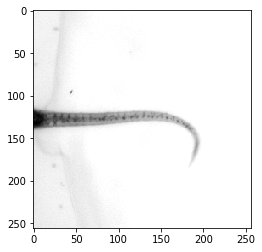

In [10]:
plt.imshow(event[25], cmap='gray')
plt.show()